In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv("data/titanic.csv", index_col="PassengerId")
df.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


# Exploratory Data Analysis (EDA)

### Target

In [3]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Numeric vs Target

/home/dimas-cahyo/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dimas-cahyo/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


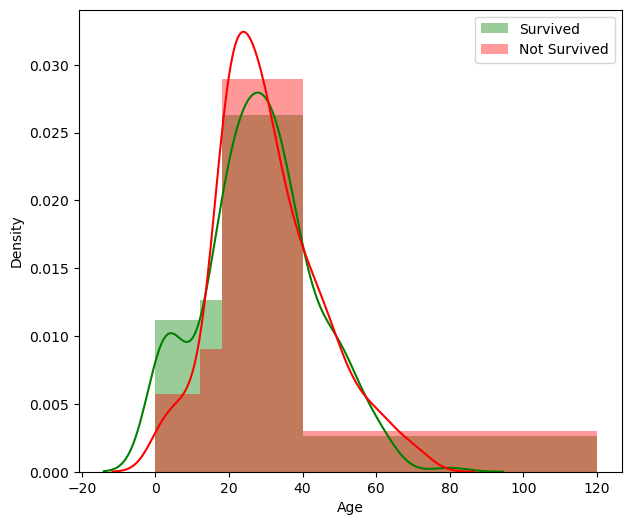

In [4]:
plt.figure(figsize=(7, 6))
sns.distplot(df.Age[df.Survived == 1], label="Survived", bins=[0, 12, 18, 40, 120], color="g")
sns.distplot(df.Age[df.Survived == 0], label="Not Survived", bins=[0, 12, 18, 40, 120], color="r")
plt.legend()

/home/dimas-cahyo/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dimas-cahyo/miniconda3/envs/jcopml/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


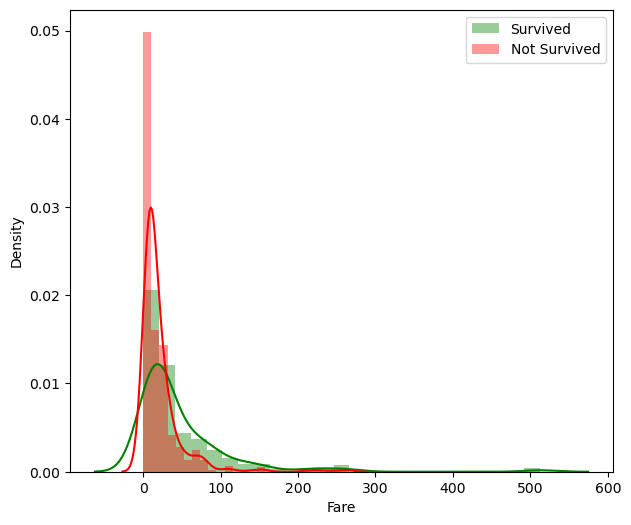

In [5]:
plt.figure(figsize=(7, 6))
sns.distplot(df.Fare[df.Survived == 1], label="Survived", bins=25, color="g")
sns.distplot(df.Fare[df.Survived == 0], label="Not Survived", bins=25, color="r")
plt.legend()

### Categoric / Ordinal vs Target

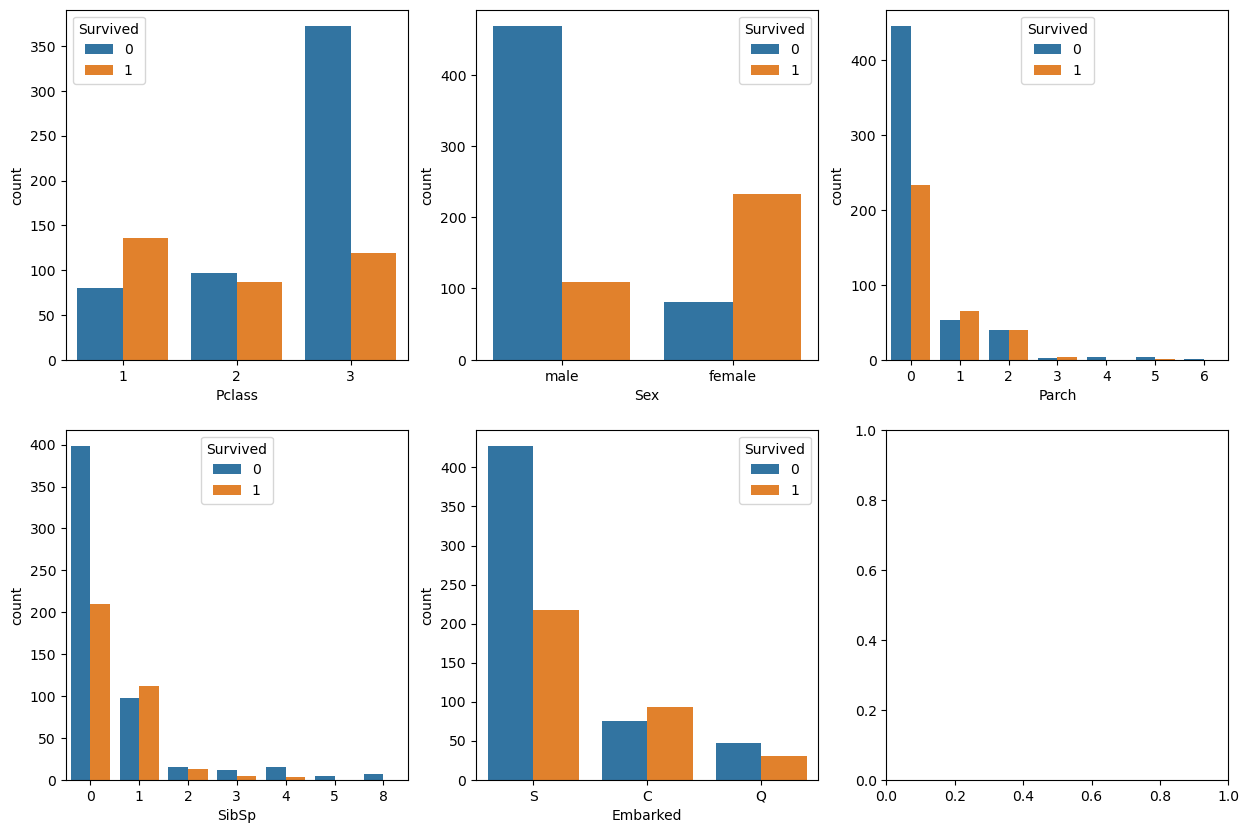

In [6]:
cat_var = ["Pclass", "Sex", "Parch", "SibSp", "Embarked"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(x=cat, data=df, hue="Survived", ax=ax)

### Pandas Crosstab (Optional)

In [7]:
# pd.crosstab(df.Pclass, df.Survived)
pd.crosstab(df.Pclass, df.Survived, normalize="index")

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


# Feature Engineering

### Adding feature => isAlone

In [8]:
df["isAlone"] = (df.SibSp == 0) & (df.Parch == 0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False
2,1,1,female,38.0,1,0,71.2833,C,False
3,1,3,female,26.0,0,0,7.9250,S,True
4,1,1,female,35.0,1,0,53.1000,S,False
5,0,3,male,35.0,0,0,8.0500,S,True


### Binning

In [9]:
df.Age = pd.cut(df.Age, [0, 5, 12, 18, 40, 120], labels=["balita", "anak-anak", "remaja", "dewasa", "lansia"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,S,False
2,1,1,female,dewasa,1,0,71.2833,C,False
3,1,3,female,dewasa,0,0,7.9250,S,True
4,1,1,female,dewasa,1,0,53.1000,S,False
5,0,3,male,dewasa,0,0,8.0500,S,True


In [10]:
df.Fare = pd.cut(df.Fare, [0, 25, 100, 600], labels=["murah", "mahal", "eksekutif"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,murah,S,False
2,1,1,female,dewasa,1,0,mahal,C,False
3,1,3,female,dewasa,0,0,murah,S,True
4,1,1,female,dewasa,1,0,mahal,S,False
5,0,3,male,dewasa,0,0,murah,S,True


# Dataset Splitting

In [11]:
X = df.drop(columns=["Survived"])
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((178, 8), (713, 8), (178,), (713,))

# Preprocessor

In [12]:
from jcopml.pipeline import cat_pipe, num_pipe

In [15]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(scaling="minmax"), ["SibSp", "Parch"]),
    ("categoric", cat_pipe(encoder="onehot"), ["Pclass", "Sex", "Age", "Fare", "Embarked", "isAlone"]),
])

# Training

In [17]:
from jcopml.tuning import grid_search_params as gsp

In [18]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['SibSp',
                                                                          'Parch']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                           

In [19]:
model.best_params_

{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__weights': 'uniform'}

In [20]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8258426966292135, 0.7896213183730715)